In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

sns.set_style("whitegrid")

### Read in samples for origin ARS313, to set up the annotation of the nucleosome areas

## Wildtype

In [2]:
load_dir =  "ARS313"

In [3]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS313_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS313_end_LexA.txt")

### Load file for feature annotation

In [4]:
####feature annotation
#anno = pd.read_csv(load_dir + "/Features from ARS313_end_LexA  (31 .. 1076).txt", sep  = "\t", 
 #                         header = None, index_col = 0)
##anno.columns = ["position", "length"]

##anno = pd.read_csv(load_dir + "/coordinates_ARS313.txt", sep  = "\t", 
##                          header = None, index_col = 0)

#Third version of annotation -> this is the current version we are using in the revision
#anno = pd.read_csv(load_dir + "/ARS313_80bp.txt", sep  = "\t", 
#                   header = None, index_col = 0)

##Fourth annotation
#anno = pd.read_csv(load_dir + "/coordinates_ARS313_v4.csv", sep  = ",", 
#                          header = None, index_col = 0)
#anno.columns = ["position"]

#anno.index = anno.index.astype("string")
#anno.index = anno.index.str.strip()

#anno["pos_start"] = anno.position.str.split(".").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split(".").str[2].astype(int) -1

#anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

#anno["length"] = (anno.pos_stop + 1) - anno.pos_start

In [5]:
#anno.rename(index = {"+3ns" : "ns+3",
#                   "+2L":"L+2",
#                   "+2ns": "ns+2", 
#                   "-1L" : "L-1",
#                   "+1ns": "ns+1",
#                   "ARS313": "ARS313",
#                   "-1ns": "ns-1",
#                   "-2ns":"ns-2",
#                   "-2L":"L-2",
#                   "-3ns":"ns-3"}, inplace = True)

## An alternative approach to predefined features would be to divide the locus into a number of windows with fixed sizes. Start with a window size of 100 nt and test the effect on clustering

In [6]:
## an alternative approach to predefined features would be to divide the 
#locus into a number of windows with fixed sizes. Start with a window size of 100 nt and 
# test the effect on clustering 

windowsize = 30 #if the windowsize is too small, statistical tests per segment get more difficult to interpret

d = {"pos_start":list(range(0, wt_rep3.shape[1], windowsize)),
            "pos_stop":list(range((windowsize -1) , wt_rep3.shape[1], windowsize)) + [wt_rep3.shape[1]]}
anno = pd.DataFrame(d,
            index = list(range(1, wt_rep3.shape[1]//windowsize + 2)))
anno["length"] = (anno.pos_stop +1) - anno.pos_start

anno["position"] = "x"

In [7]:
anno.head()

,pos_start,pos_stop,length,position
1,0,29,30,x
2,30,59,30,x
3,60,89,30,x
4,90,119,30,x
5,120,149,30,x


In [8]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS313_end_LexA_minus.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS313_end_LexA_minus.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS313_end_LexA_minus.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS313_end_LexA_minus.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS313_end_LexA_minus.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS313_end_LexA_minus.txt")

In [9]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2.shape, wt_rep2_rev.shape)

True
True
(493, 1033) (492, 1036)


In [10]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-3]), axis = 0)
#subsample wt_rep2_rev to 780 reads
wt_rep2_sub = subsample(wt_rep2, 492)
wt_rep2_join = np.concatenate((wt_rep2_sub, wt_rep2_rev[:, :-3]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

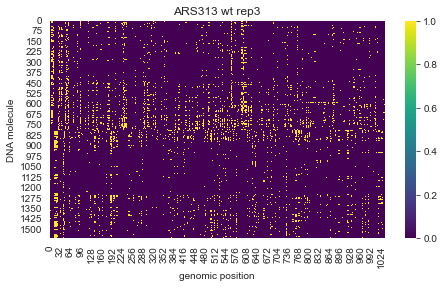

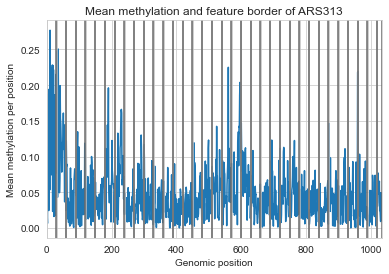

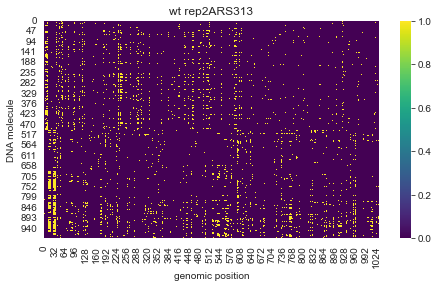

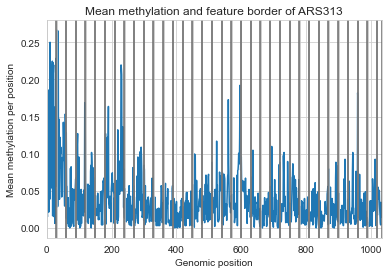

In [11]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title("wt rep2" + load_dir)
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

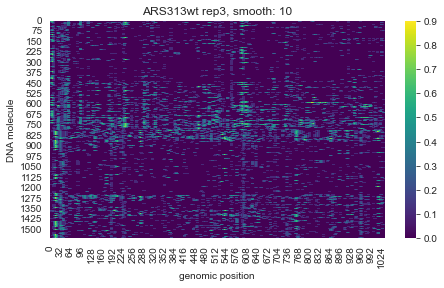

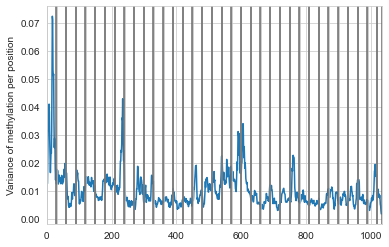

In [12]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 1, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [13]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([9.77734753, 2.80735721, 0.96805421, ..., 1.3552759 , 7.45401742,
       1.74249758])

<AxesSubplot:>

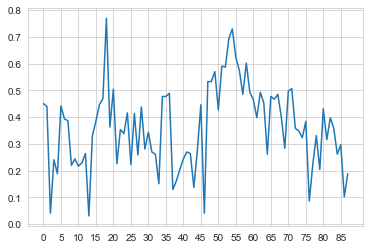

In [14]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

#entropy(ARS305_wt[:,6])
#np.unique(ARS305_wt[:,6], return_counts = True)

g = sns.lineplot(x = range(630-542), y = np.apply_along_axis(entropy, 0, wt_rep3[:, 542:630]))
g.set_xticks(range(0, 630-542, 5))
g

<AxesSubplot:title={'center':'ARS313 wt rep3, entropy per position'}, ylabel='entropy'>

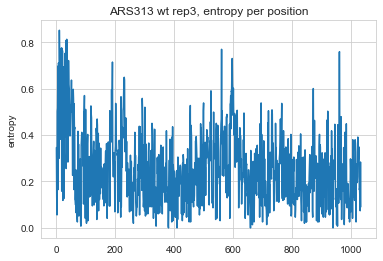

In [15]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [16]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.851224335262138, 1029)

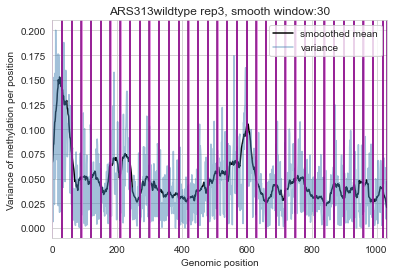

In [17]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  "wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

In [18]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS313_end_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape) 

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS313_REP2_780READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape) 

(780, 1033) (780, 1036)
(780, 1033) (780, 1036)


In [19]:
#join the plus and minus strand
dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev[:, :-3]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2, dies6_rep2_rev[:, :-3]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

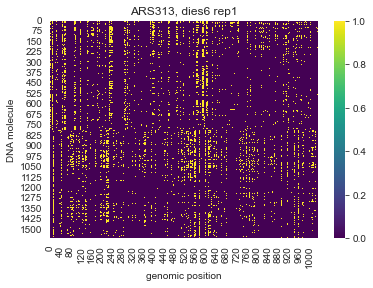

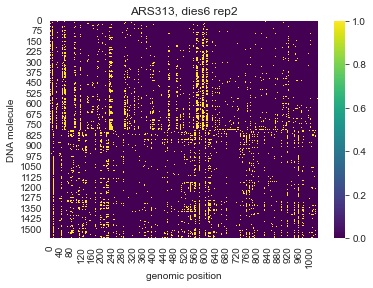

In [20]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()


sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

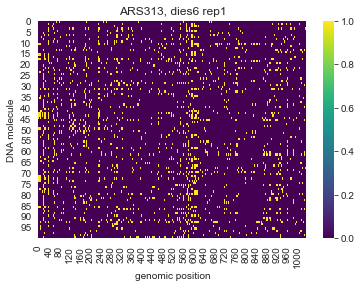

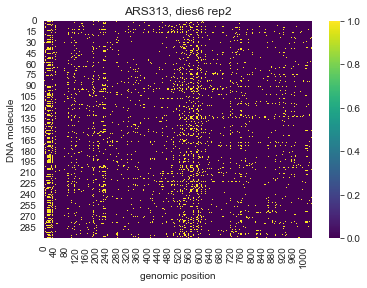

In [21]:
#subsample to the same number of molecules than in 316
#rep1 -> 83
#rep2 -> 301

#def subsample(df, n):
#    np.random.seed(0)
#    return df[np.random.RandomState(seed=24).choice(len(df), n)]

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

test1 = subsample(dies6_rep1, 100)
test2 = subsample(dies6_rep2, 300)

sns.heatmap(test1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(test2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

In [22]:
#subsample dies6 replicates to the same size as in 316, and oberserve the effect on differential
#methylation per feature in the below output

#dies6_rep1 = subsample(dies6_rep1, 83)
#dies6_rep2 = subsample(dies6_rep2, 301)

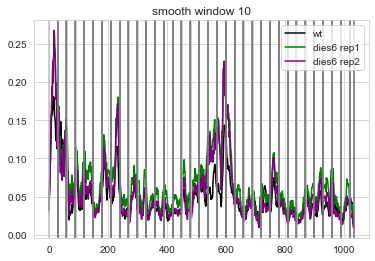

(21530.0, 2.5747333270307454e-144)

In [23]:
#smooth_window=1
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [24]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=48827.5, pvalue=6.103394552215084e-108)

## Load data for mutant disw2

In [25]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS313_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)

disw2_rep2 = np.genfromtxt(load_dir + "/ARS313_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1033) (780, 1036)
(780, 1033) (780, 1036)


In [26]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-3]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-3]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

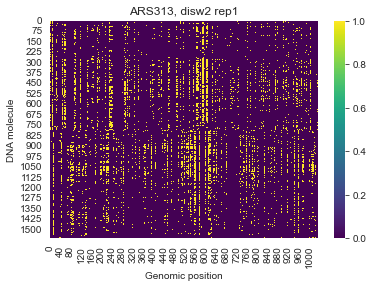

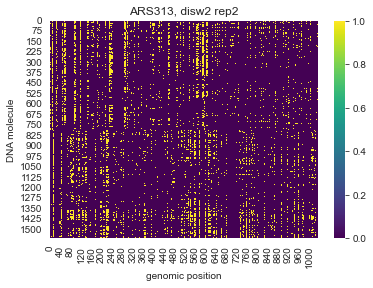

In [27]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()


sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

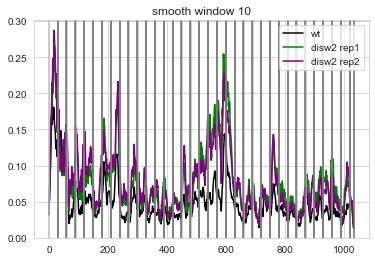

In [28]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [29]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(254272.5, 0.8283481167836464)

In [30]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1033.0,0.049472,0.042051,0.0,0.018590,0.040385,0.066026,0.276923,1560
wt_rep2,1033.0,0.038092,0.038645,0.0,0.012195,0.026423,0.049797,0.266260,984
dies6_rep1,1033.0,0.068616,0.070726,0.0,0.014103,0.050641,0.093590,0.418590,1560
dies6_rep2,1033.0,0.056691,0.066784,0.0,0.012179,0.037179,0.071795,0.428205,1560
disw2_rep1,1033.0,0.080577,0.079684,0.0,0.014744,0.060256,0.117949,0.416667,1560
disw2_rep2,1033.0,0.079953,0.077885,0.0,0.020513,0.057051,0.112821,0.435256,1560


### Normalise each experiment to the emthylation level of the spike-in control and pool replicates

In [31]:
"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""

'wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()\nwt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()\n\npooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)\n\n#dies6\ndies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()\ndies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()\n\npooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)\n\n#disw2\ndisw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()\ndisw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()\n\npooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)'

In [32]:
#normalization to the mean frequency of methylation of the same origin:

"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.flatten().mean(axis = 0)
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.flatten().mean(axis = 0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.flatten().mean(axis = 0)
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.flatten().mean(axis = 0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.flatten().mean(axis = 0)
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.flatten().mean(axis = 0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""

#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)




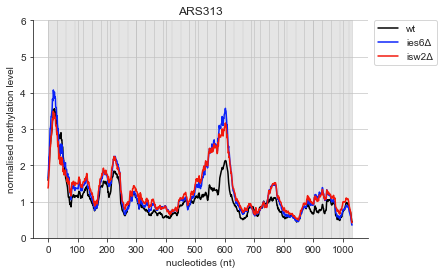

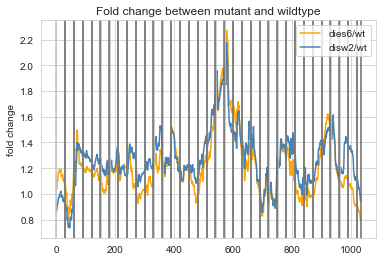

In [33]:
N=30

with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        for feature in anno.index:
            plt.fill_betweenx(range(0,7), 
                      anno.loc[feature, "pos_start"],
                      anno.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_wt_mut.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
for left_border in anno.loc[:, "pos_start"]:
    plt.axvline(left_border, color = "silver")
for right_border in anno.loc[:, "pos_stop"]:
    plt.axvline(right_border, color = "dimgray")
plt.show()

In [34]:
#sns.axes_style()

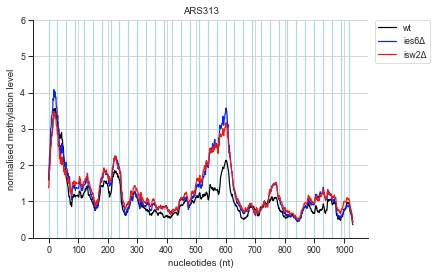

In [35]:
#For the fixed window sizes, plot the smoothened tracks and the start of each window
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False, 
                             "font_scale": 0.6}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window30.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

### Compare mean distributions between pooled replicates and pooled wildtype with paired wilcoxon test

In [36]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [37]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "less").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "less").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [38]:
segments.head(n=15)
#segments.to_csv(load_dir + "/ARS313_pooled_samples_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.014091,0.091788
2,30,59,30,0.837407,0.976065
3,60,89,30,0.011922,0.014885
4,90,119,30,0.003116,0.000827
5,120,149,30,0.001373,0.000134
6,150,179,30,0.298136,0.058478
7,180,209,30,0.014091,0.025180
8,210,239,30,0.004883,0.002085
9,240,269,30,0.035495,0.002917
10,270,299,30,0.778645,0.214984


In [39]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation mutants compared to wildtype?")
print("       P-value below: ", pvalue)
significant = segments.loc[(segments["p_value_dies6"] < pvalue) | (segments["p_value_disw2"] < pvalue)]
significant

       Which sites have a different mean methylation mutants compared to wildtype?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
1,0,29,30,0.014091,0.091788
3,60,89,30,0.011922,0.014885
4,90,119,30,0.003116,0.000827
5,120,149,30,0.001373,0.000134
7,180,209,30,0.014091,0.025180
8,210,239,30,0.004883,0.002085
9,240,269,30,0.035495,0.002917
11,300,329,30,0.044809,0.000568
12,330,359,30,0.063700,0.017504
15,420,449,30,0.004586,0.002388


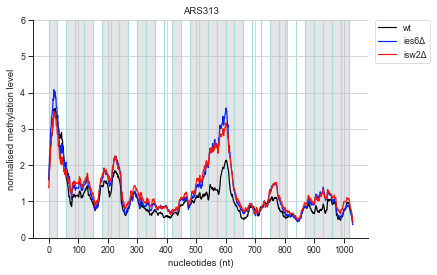

In [40]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        for left_border in anno.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "silver", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir 
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100))
        plt.xlabel("nucleotides (nt)")
        plt.ylabel("normalised methylation level")
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window30_union_selection.svg", dpi=300, bbox_inches = "tight")
        plt.show()

In [41]:
##Regions significant for disw2:
#print("       Which sites have a different mean methylation in the disw2 mutant?")
#print("       P-value below: ", pvalue)
#segments.loc[(segments["p_value_disw2"] < pvalue)]

### Compare pooled wildtype to mutant replicates, then filter regions

In [42]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [43]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

In [44]:
#segments.to_csv(load_dir + "/ARS313_separate_replicates_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
1,0,29,30,0.021286,0.067676,0.442711,0.132887
2,30,59,30,0.238611,0.429968,0.021286,0.093778
3,60,89,30,0.021286,0.041014,0.031436,0.025221
4,90,119,30,0.001781,0.036921,0.013292,0.001053
5,120,149,30,0.000227,0.230105,0.014119,0.000176
6,150,179,30,0.358103,0.991374,0.247337,0.047870
7,180,209,30,0.029770,0.107195,0.045484,0.041014
8,210,239,30,0.006232,0.021286,0.026666,0.001781
9,240,269,30,0.009767,0.939673,0.010397,0.002558
10,270,299,30,0.566635,0.014119,0.753873,0.176551


In [45]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
8,210,239,30,0.006232,0.021286,0.026666,0.001781
18,510,539,30,0.005834,0.011765,0.005834,0.001426
19,540,569,30,0.000660,0.000479,0.000519,0.000375
20,570,599,30,0.002061,0.000519,0.003390,0.001781
21,600,629,30,0.000660,0.001053,0.000519,0.000660
26,750,779,30,0.003390,0.002558,0.008609,0.003390
32,930,959,30,0.001053,0.021286,0.007101,0.000114


In [46]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
4,90,119,30,0.001781,0.036921,0.013292,0.001053
5,120,149,30,0.000227,0.230105,0.014119,0.000176
9,240,269,30,0.009767,0.939673,0.010397,0.002558
11,300,329,30,0.005460,0.786937,0.002381,0.000714
15,420,449,30,0.001053,0.335933,0.008609,0.017897
17,480,509,30,0.002746,0.064489,0.007101,0.004463
18,510,539,30,0.005834,0.011765,0.005834,0.001426
19,540,569,30,0.000660,0.000479,0.000519,0.000375
20,570,599,30,0.002061,0.000519,0.003390,0.001781
21,600,629,30,0.000660,0.001053,0.000519,0.000660


In [47]:
#Repeat this test for the case that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis =1, inplace = True)

In [48]:
test_higher

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
1,0,29,30,0.010643,0.033838,0.221355,0.066444
2,30,59,30,0.880694,0.785016,0.989357,0.953111
3,60,89,30,0.010643,0.020507,0.015718,0.012610
4,90,119,30,0.000890,0.018460,0.006646,0.000527
5,120,149,30,0.000114,0.115053,0.007059,0.000088
6,150,179,30,0.179051,0.495687,0.123669,0.023935
7,180,209,30,0.014885,0.053598,0.022742,0.020507
8,210,239,30,0.003116,0.010643,0.013333,0.000890
9,240,269,30,0.004883,0.530164,0.005198,0.001279
10,270,299,30,0.283317,0.992941,0.623063,0.088276


In [49]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.010643,0.020507,0.015718,0.012610
4,90,119,30,0.000890,0.018460,0.006646,0.000527
8,210,239,30,0.003116,0.010643,0.013333,0.000890
18,510,539,30,0.002917,0.005883,0.002917,0.000713
19,540,569,30,0.000330,0.000240,0.000260,0.000188
20,570,599,30,0.001030,0.000260,0.001695,0.000890
21,600,629,30,0.000330,0.000527,0.000260,0.000330
26,750,779,30,0.001695,0.001279,0.004304,0.001695
31,900,929,30,0.002916,0.018460,0.005198,0.000768
32,930,959,30,0.000527,0.010643,0.003550,0.000057


In [50]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
3,60,89,30,0.010643,0.020507,0.015718,0.012610
4,90,119,30,0.000890,0.018460,0.006646,0.000527
5,120,149,30,0.000114,0.115053,0.007059,0.000088
7,180,209,30,0.014885,0.053598,0.022742,0.020507
8,210,239,30,0.003116,0.010643,0.013333,0.000890
9,240,269,30,0.004883,0.530164,0.005198,0.001279
11,300,329,30,0.002730,0.606531,0.001191,0.000357
12,330,359,30,0.020507,0.321002,0.018460,0.012610
15,420,449,30,0.000527,0.167966,0.004304,0.008949
17,480,509,30,0.001373,0.032245,0.003550,0.002231


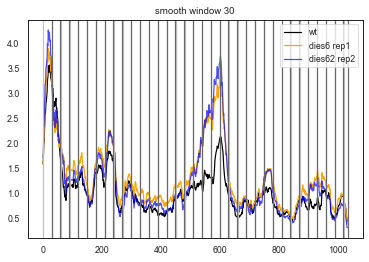

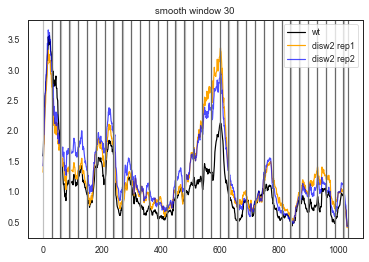

In [51]:
# How does that look over the entire sequence?
sns.set_style("white")
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [52]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [53]:
#20230214: for the fixed window size approach, only select significantly different regions
saved = anno.copy()
anno = anno.iloc[anno.index.intersection(significant.index)-1,:]

In [54]:
"""#normalize the count matrices to the max of averages of the respective sample
wt_rep3_maxnorm = max_normalise_array(wt_rep3)
wt_rep2_maxnorm = max_normalise_array(wt_rep2)

dies6_rep1_maxnorm = max_normalise_array(dies6_rep1)
dies6_rep2_maxnorm = max_normalise_array(dies6_rep2)

disw2_rep1_maxnorm = max_normalise_array(disw2_rep1)
disw2_rep2_maxnorm = max_normalise_array(disw2_rep2)
"""

#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls
#normalise to the nucleosomal array spike-ins

wt_rep3_maxnorm = wt_rep3/mean_array_wt_rep3
wt_rep2_maxnorm = wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


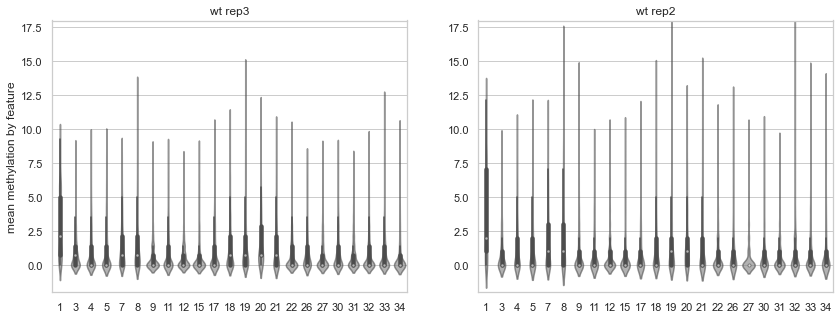

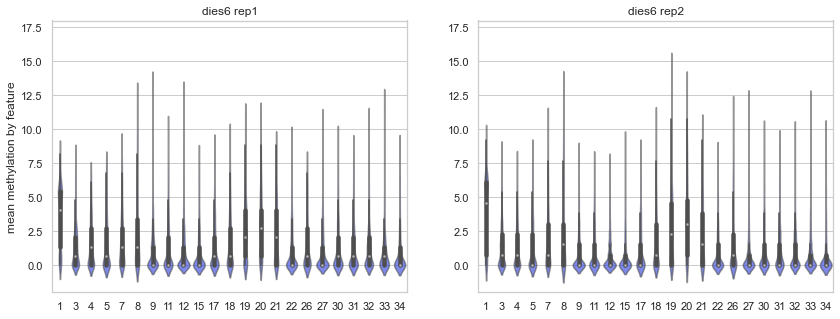

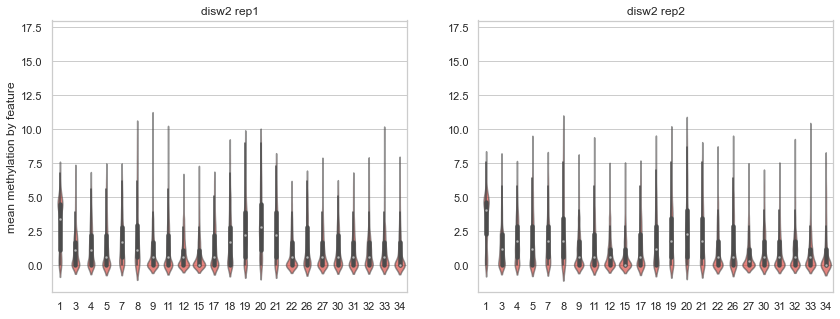

In [55]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_wt_revision.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_dies6_revision.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_disw2_revision.tif")
plt.show()

In [56]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt rep2"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "ies6Δ"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "isw2Δ"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

In [57]:
#only use this for feature-based annotation, not for fixed window sizes
#methylation_rep1.feature = pd.Categorical(methylation_rep1['feature'],
#                                   categories=['ns+3', 'L+2', 'ns+2', 'ns+1', 'ARS313', 'ns-1', 'L-1', 'ns-2', 'L-2',
#       'ns-3'],
#                                   ordered=True)


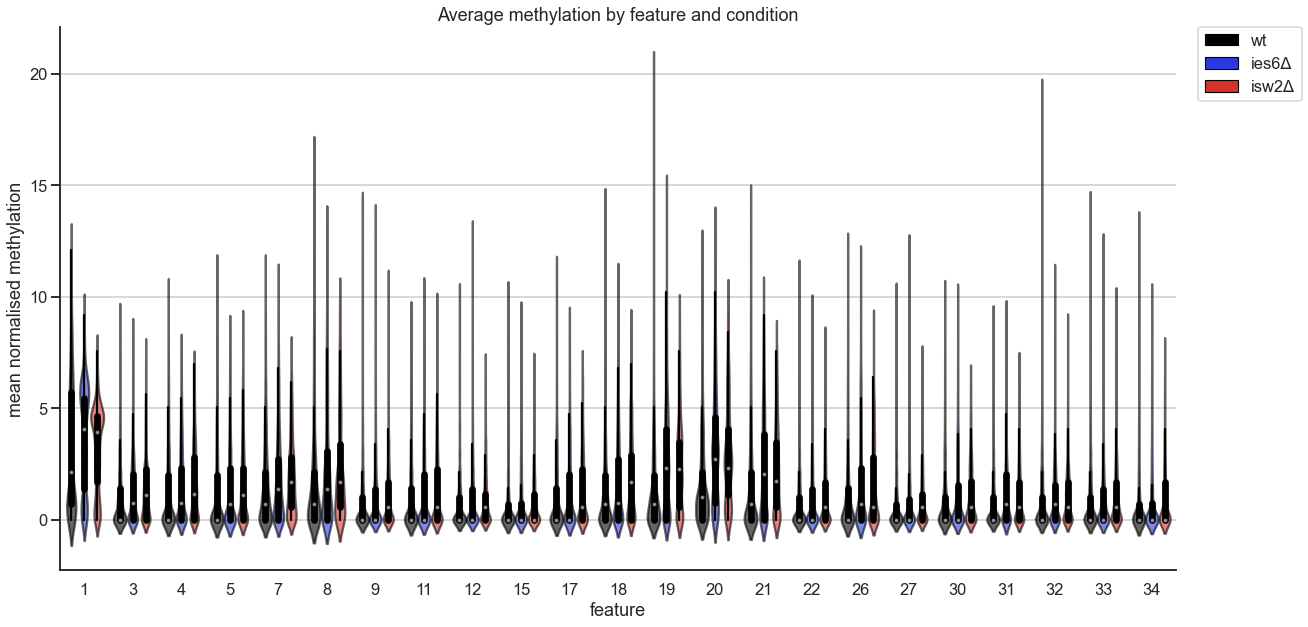

In [58]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

#sns.set(font_scale=1.5)
#sns.set_style("whitegrid")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False,
                                 'xtick.bottom': False}):
    sns.set_context("talk")
    #plt.figure(figsize = (10,7))
    plt.figure(figsize = (20,10)) # more features need more space (-> use for small window sizes)
    ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.setp(ax.collections, alpha = 0.6)
    plt.title("Average methylation by feature and condition")
    plt.ylabel("mean normalised methylation")
    #plt.savefig(load_dir + "/plots/ARS313_pooled_norm_av_methylation_by_feature_anno3_revision.pdf", 
    #            dpi = 300, bbox_inches = "tight")
    plt.savefig(load_dir + "/plots/ARS313_pooled_norm_av_methylation_by_feature_revision_window100.svg", 
                dpi = 300, bbox_inches = "tight")
    plt.show()

In [59]:
#methylation_rep1.to_csv(load_dir + "/ARS313_violinplots_annotation_v3.csv")

In [60]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "ies6Δ"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "ies6Δ"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "isw2Δ"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "isw2Δ"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

In [61]:
#methylation_features.to_csv(load_dir + "/ARS313_feature_methylation_window30_union_selected.csv")

1.3940624156021406
0.0 20.188968747476377
0.6797043014407013 4.078225808644207


<AxesSubplot:ylabel='norm_methylation'>

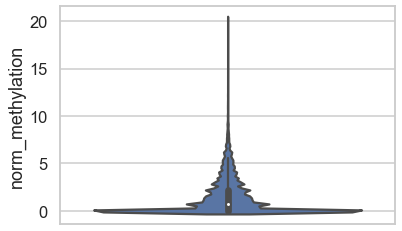

In [62]:
print(methylation_features.norm_methylation.mean())
print(methylation_features.norm_methylation.min(), methylation_features.norm_methylation.max())
print(methylation_features.norm_methylation.quantile(0.50), methylation_features.norm_methylation.quantile(0.90))
sns.violinplot(data = methylation_features, y = "norm_methylation")

In [63]:
"""test = wt_rep3_feata_me
test2 = dies6_rep1_feat_me

from scipy.stats import mannwhitneyu

scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue

for number in range(10):
    np.random.shuffle(test[:, 7])
    np.random.shuffle(test2[:, 7])
    print(scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue)
 """

'test = wt_rep3_feata_me\ntest2 = dies6_rep1_feat_me\n\nfrom scipy.stats import mannwhitneyu\n\nscipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue\n\nfor number in range(10):\n    np.random.shuffle(test[:, 7])\n    np.random.shuffle(test2[:, 7])\n    print(scipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue)\n '

In [64]:
feat_me_wt_rep3

,1,3,4,5,7,8,9,11,12,15,...,22,26,27,30,31,32,33,34,molecule,strand
0,1.428360,2.85672,2.142540,3.570901,4.999261,1.42836,0.71418,0.00000,0.00000,0.0,...,0.00000,0.714180,0.000000,0.00000,0.71418,0.00000,0.00000,0.00000,0,plus
1,2.856720,1.42836,3.570901,4.285081,3.570901,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.714180,0.000000,0.71418,0.71418,0.00000,0.00000,0.00000,1,plus
2,0.714180,2.85672,1.428360,3.570901,4.285081,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.000000,0.000000,0.71418,0.71418,0.00000,0.00000,0.00000,2,plus
3,2.856720,1.42836,4.285081,4.285081,0.714180,0.71418,0.00000,0.00000,0.00000,0.0,...,0.00000,0.000000,0.000000,0.00000,0.71418,0.00000,0.00000,0.00000,3,plus
4,4.999261,0.00000,3.570901,0.000000,0.000000,0.71418,0.00000,2.14254,0.71418,0.0,...,0.00000,1.428360,0.714180,0.71418,0.71418,0.71418,0.00000,0.00000,4,plus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,0.000000,0.00000,0.000000,2.142540,3.570901,0.71418,0.00000,0.00000,0.00000,0.0,...,1.42836,1.428360,0.714180,0.00000,0.00000,0.00000,0.71418,0.71418,1555,minus
1556,4.999261,0.00000,1.428360,0.000000,2.142540,2.14254,0.71418,0.00000,1.42836,0.0,...,0.00000,4.999261,0.000000,2.14254,1.42836,2.14254,0.71418,0.00000,1556,minus
1557,4.285081,1.42836,0.714180,0.714180,2.856720,2.85672,2.85672,1.42836,0.71418,0.0,...,0.71418,0.000000,0.000000,0.00000,0.00000,0.00000,2.85672,0.71418,1557,minus
1558,0.000000,0.00000,0.000000,0.000000,0.714180,0.71418,0.00000,0.00000,0.00000,0.0,...,1.42836,4.285081,3.570901,0.00000,0.71418,2.14254,2.85672,1.42836,1558,minus


In [65]:
from scipy.stats import mannwhitneyu

#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["wt_rep3"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep3.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]
feature_pvalues["wt_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]

feature_pvalues

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
1,0,29,30,0.013001,0.000750,1.121514e-27,4.613489e-02
3,60,89,30,0.553686,0.415041,5.941119e-24,1.087952e-26
4,90,119,30,0.096271,0.024564,7.459096e-15,7.338507e-22
5,120,149,30,0.317670,0.176804,5.072593e-05,9.437538e-16
7,180,209,30,0.831946,0.772088,3.613077e-11,6.690607e-16
8,210,239,30,0.090495,0.021457,9.839351e-12,4.717910e-13
9,240,269,30,0.869723,0.821909,4.017596e-03,5.338211e-19
11,300,329,30,0.089512,0.018122,1.169633e-01,1.761808e-22
12,330,359,30,0.106826,0.025073,4.050599e-03,3.458563e-20
15,420,449,30,0.423399,0.268214,9.594054e-02,4.038611e-21


In [66]:
feature_pvalues[feature_pvalues.wt_rep3 < 2.5e-2]

#from scipy.stats import ttest_ind
#[ttest_ind(feat_me_wt_pool.loc[:, column], feat_me_wt_rep3.loc[:, column], 
#           alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
1,0,29,30,0.013001,0.000750,1.121514e-27,4.613489e-02
21,600,629,30,0.006674,0.000174,6.032715e-55,8.530532e-83
27,780,809,30,0.002097,0.000013,1.192245e-03,7.210719e-36


In [67]:
#for number in range(20):
#    test1 = np.random.randint(0, 100, 20)
#    test2 = np.random.randint(0, 100, 20)
#    print(mannwhitneyu(test1, test2, alternative = "two-sided").pvalue)


In [68]:
feature_pvalues[feature_pvalues.dies6_rep2 < 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
1,0,29,30,0.013001,0.000750,1.121514e-27,4.613489e-02
3,60,89,30,0.553686,0.415041,5.941119e-24,1.087952e-26
4,90,119,30,0.096271,0.024564,7.459096e-15,7.338507e-22
5,120,149,30,0.317670,0.176804,5.072593e-05,9.437538e-16
7,180,209,30,0.831946,0.772088,3.613077e-11,6.690607e-16
8,210,239,30,0.090495,0.021457,9.839351e-12,4.717910e-13
9,240,269,30,0.869723,0.821909,4.017596e-03,5.338211e-19
12,330,359,30,0.106826,0.025073,4.050599e-03,3.458563e-20
17,480,509,30,0.111809,0.027332,2.877035e-04,6.036878e-29
18,510,539,30,0.244730,0.110436,1.597080e-18,4.304484e-51


In [69]:
feature_pvalues[feature_pvalues.disw2_rep1 < 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
3,60,89,30,0.553686,0.415041,5.941119e-24,1.087952e-26
4,90,119,30,0.096271,0.024564,7.459096e-15,7.338507e-22
5,120,149,30,0.317670,0.176804,5.072593e-05,9.437538e-16
7,180,209,30,0.831946,0.772088,3.613077e-11,6.690607e-16
8,210,239,30,0.090495,0.021457,9.839351e-12,4.717910e-13
9,240,269,30,0.869723,0.821909,4.017596e-03,5.338211e-19
11,300,329,30,0.089512,0.018122,1.169633e-01,1.761808e-22
12,330,359,30,0.106826,0.025073,4.050599e-03,3.458563e-20
15,420,449,30,0.423399,0.268214,9.594054e-02,4.038611e-21
17,480,509,30,0.111809,0.027332,2.877035e-04,6.036878e-29


In [70]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not (column == "molecule")|(column =="strand")]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
1,0,29,30,7.996645e-23,8.488486e-06
3,60,89,30,4.362584e-33,2.458863e-48
4,90,119,30,1.022072e-23,6.182750e-56
5,120,149,30,1.937614e-12,5.562505e-42
7,180,209,30,1.297115e-12,2.463365e-24
8,210,239,30,3.611550e-15,2.859254e-26
9,240,269,30,2.627939e-09,1.324505e-39
11,300,329,30,2.446944e-06,4.214186e-32
12,330,359,30,3.493769e-05,1.108190e-28
15,420,449,30,6.231546e-07,1.487825e-26


In [71]:
feature_pvalues[feature_pvalues.dies6_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
1,0,29,30,7.996645e-23,8.488486e-06
3,60,89,30,4.362584e-33,2.458863e-48
4,90,119,30,1.022072e-23,6.182750e-56
5,120,149,30,1.937614e-12,5.562505e-42
7,180,209,30,1.297115e-12,2.463365e-24
8,210,239,30,3.611550e-15,2.859254e-26
9,240,269,30,2.627939e-09,1.324505e-39
11,300,329,30,2.446944e-06,4.214186e-32
12,330,359,30,3.493769e-05,1.108190e-28
15,420,449,30,6.231546e-07,1.487825e-26


In [72]:
feature_pvalues[feature_pvalues.disw2_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
1,0,29,30,7.996645e-23,8.488486e-06
3,60,89,30,4.362584e-33,2.458863e-48
4,90,119,30,1.022072e-23,6.182750e-56
5,120,149,30,1.937614e-12,5.562505e-42
7,180,209,30,1.297115e-12,2.463365e-24
8,210,239,30,3.611550e-15,2.859254e-26
9,240,269,30,2.627939e-09,1.324505e-39
11,300,329,30,2.446944e-06,4.214186e-32
12,330,359,30,3.493769e-05,1.108190e-28
15,420,449,30,6.231546e-07,1.487825e-26


In [73]:
#feature_pvalues.to_csv(load_dir + "/ARS313_p_values_avg_feature_methylation.csv")

### Use peak detection to characterise peaks along the entire origin

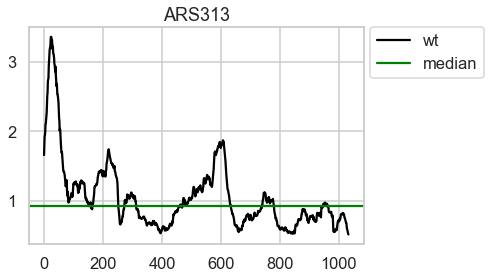

In [74]:
N=40
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [75]:
from scipy import signal

x = pooled_wt_smoothed
peaks, properties = signal.find_peaks(x, width=20, 
                               rel_height=0.9,
                               #prominence = (None, 0.8), 
                               height= np.median(x)
                              )
properties

{'peak_heights': array([3.35938038, 1.293302  , 1.74200094, 1.12191836, 1.37391162,
        1.87069359, 1.1238252 , 0.97726638]),
 'prominences': array([1.69994996, 0.31622869, 0.86146006, 0.46037472, 0.17197973,
        1.33558748, 0.57147126, 0.44750404]),
 'left_bases': array([  0,  83, 163, 259, 395, 395, 660, 843]),
 'right_bases': array([1032,  163,  395,  395,  569, 1032, 1032, 1032]),
 'widths': array([ 55.65037819,  59.2917197 ,  85.09722437,  81.64571877,
         28.46981037, 211.88982691, 127.77086425, 129.7970608 ]),
 'width_heights': array([1.82942541, 1.00869618, 0.96668688, 0.70758111, 1.21912986,
        0.66866486, 0.60950106, 0.57451274]),
 'left_ips': array([  1.26264178,  85.64167678, 166.34765976, 263.43390121,
        540.1310794 , 434.08603125, 670.63213138, 851.10963907]),
 'right_ips': array([ 56.91301997, 144.93339649, 251.44488414, 345.07961998,
        568.60088977, 645.97585816, 798.40299563, 980.90669987])}

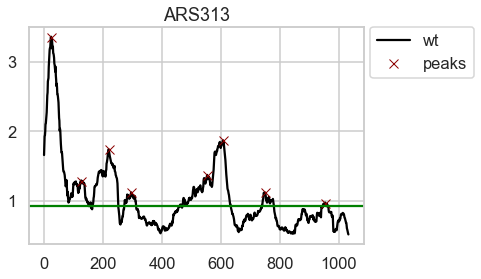

In [76]:
sns.set_context("talk")

plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
#plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
#            xmax=properties["right_ips"], color = "darkred")

#plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
#         fontsize = 13, color="darkred")
plt.title(load_dir)
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "peaks"])
plt.show()

In [77]:
print(properties["peak_heights"].mean(axis=0))
print(properties["prominences"].mean(axis=0))

1.6077873083152658
0.7330694926368868


## Use peak detection to estimate the size of the nucleosome-free region

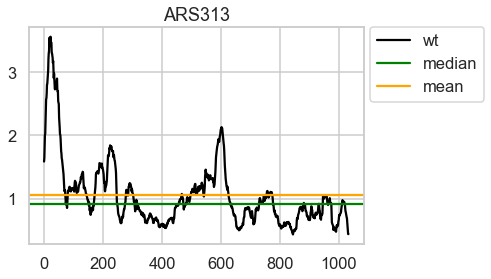

In [78]:
N=30
pooled_wt_smoothed = np.convolve(pooled_wt, np.ones(N)/N, mode="same")

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = pooled_wt_smoothed, color = "black", label = "wt")
plt.axhline(np.median(pooled_wt_smoothed,axis=0), color ="green", label = "median")
plt.axhline(np.mean(pooled_wt_smoothed,axis=0), color ="orange", label = "mean")
plt.title(load_dir)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0,
          labels = ["wt", "median", "mean"])

In [79]:
from scipy import signal

x = pooled_wt_smoothed[460:630]
peaks, properties = signal.find_peaks(x, width=30
                              )
properties

{'prominences': array([1.16856155]),
 'left_bases': array([14]),
 'right_bases': array([169]),
 'widths': array([30.74646054]),
 'width_heights': array([1.54713189]),
 'left_ips': array([122.01739272]),
 'right_ips': array([152.76385326])}

In [80]:
signal.peak_widths(x, peaks, rel_height = 0.9)[0]

array([82.07195661])

Text(0.5, 1.0, 'Measure peak width at 90% rel height, ARS313')

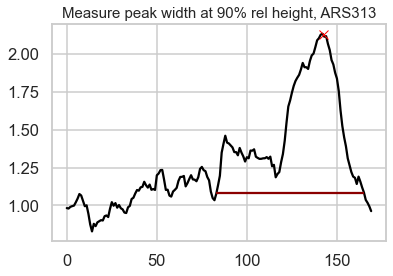

In [81]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "red")
plt.hlines(*signal.peak_widths(x, peaks, rel_height = 0.9)[1:], color ="darkred")
plt.title( "Measure peak width at 90% rel height, ARS313", fontsize = 15)

In [82]:
pooled_dies6_smoothed = np.convolve(pooled_dies6, np.ones(N)/N, mode = "same")[480:659]
pooled_disw2_smoothed = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same")[480:659]

## Use the find_peak function on the mutants to explore the calculated peak width there

In [83]:
#look for a peak and it's properties in the same area for mutant strains:

peaks_dies6, prop_dies6 = signal.find_peaks(pooled_dies6_smoothed, width=20)
peaks_disw2, prop_disw2 = signal.find_peaks(pooled_disw2_smoothed, width=20)
#prop_dies6, prop_disw2, properties

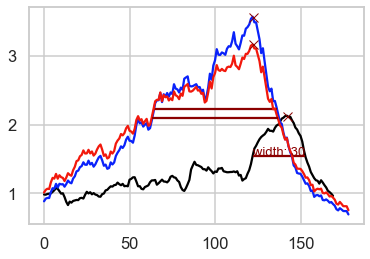

In [84]:
plt.plot(x, color = "black")
plt.plot(peaks, x[peaks], "x", color = "darkred")
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "darkred")
plt.text(x = properties["left_ips"],y=properties["width_heights"], s = ("width: " + str(int(properties["widths"]))),
         fontsize = 13, color="darkred")

plt.plot(pooled_dies6_smoothed, color = "#0a22fa")
plt.plot(peaks_dies6, pooled_dies6_smoothed[peaks_dies6], "x", color = "darkred")
plt.hlines(y=prop_dies6["width_heights"], xmin=prop_dies6["left_ips"],
            xmax=prop_dies6["right_ips"], color = "darkred")

plt.plot(pooled_disw2_smoothed, color = "#f2180c")
plt.plot(peaks_disw2, pooled_disw2_smoothed[peaks_disw2], "x", color = "darkred")
plt.hlines(y=prop_disw2["width_heights"], xmin=prop_disw2["left_ips"],
            xmax=prop_disw2["right_ips"], color = "darkred")

plt.show()

### Define the width of the nucleosome-free region as P10 - the peak width at 10% of peak height, from the wild type sample. This represents the cutoff for this origin for "nucleosome free"

In [85]:
width = signal.peak_widths(x, peaks, rel_height = 0.9)

In [86]:
peak_indices_dies6 = np.where(pooled_dies6_smoothed > width[1])[0]
width_dies6 = peak_indices_dies6[-1] - peak_indices_dies6[0]
print("peak width for dies6: ", width_dies6)

peak width for dies6:  148


In [87]:
peak_indices_disw2 = np.where(pooled_disw2_smoothed > width[1])[0]
width_disw2 = peak_indices_disw2[-1] - peak_indices_disw2[0]
print("peak width for disw2: ", width_disw2)

peak width for disw2:  153


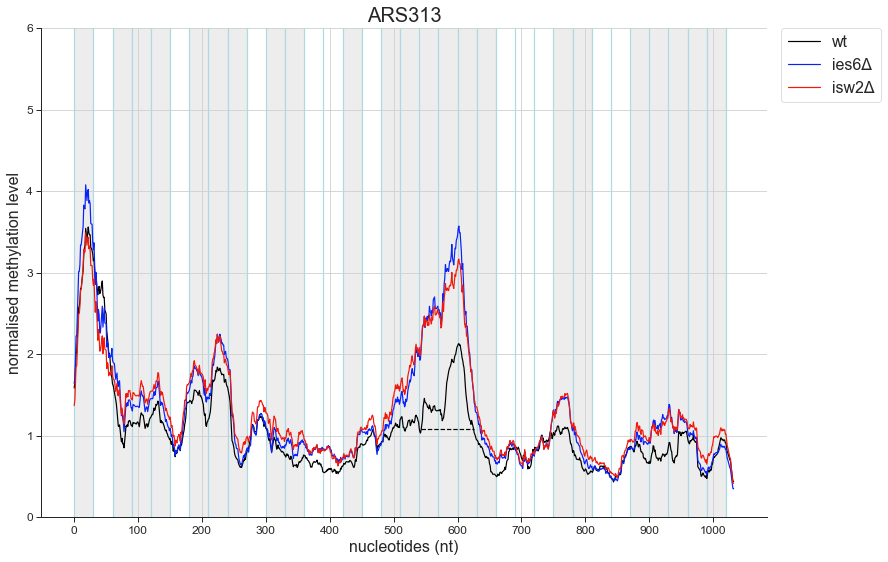

In [88]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        for left_border in saved.loc[:, "pos_start"]:
            plt.axvline(left_border, color = "lightblue")
        for feature in significant.index:
            plt.fill_betweenx(range(0,7), 
                      significant.loc[feature, "pos_start"],
                      significant.loc[feature, "pos_stop"], 
                      color = "lightgray", alpha = 0.4)
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
             color = "black", 
            label = "wt")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        plt.ylim(0, 6)
        plt.xticks(range(0, wt_rep3_minmax.shape[0], 100), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel("nucleotides (nt)", fontsize = 16)
        plt.ylabel("normalised methylation level", fontsize = 16)
        
        plt.hlines(y=width[1], # properties["width_heights"],
                   xmin=width[2]+460,
            xmax=width[3]+460, color = "black", linestyles = "dashed")
        
        #plt.savefig(load_dir + "/plots/ARS313_smoothed_profiles_revision_window30_union_selection_peak_width.svg", dpi=300, bbox_inches = "tight")
        plt.show()

## Find valleys in normalised single-molecule data around the origin as footprints of Mcm double hexamers

In [89]:
# https://openwritings.net/pg/python/python-find-peaks-and-valleys-chart-using-scipysignalargrelextrema

In [90]:
#To smoothen the signal in a sliding window across columns, either use pandas rolling in combination with mean, or 
# numpys convolve while applying it along an axis

# df.rolling(30, center=True, axis = 1, closed="both").mean()

smooth_window =30
def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")

In [91]:
# Concatenate normalised data from replicates 
wt_norm = np.concatenate((wt_rep3_maxnorm, wt_rep2_maxnorm), axis = 0)
dies6_norm = np.concatenate((dies6_rep1_maxnorm, dies6_rep2_maxnorm), axis =0)
disw2_norm = np.concatenate((disw2_rep1_maxnorm, disw2_rep2_maxnorm), axis =0)

In [92]:
wt_smooth = np.apply_along_axis(smooth, 1, wt_norm)
dies6_smooth = np.apply_along_axis(smooth, 1, dies6_norm)
disw2_smooth = np.apply_along_axis(smooth, 1, disw2_norm)

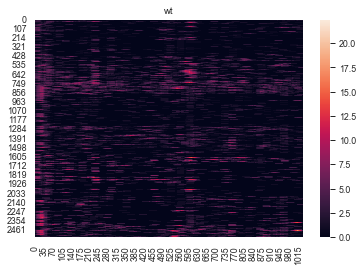

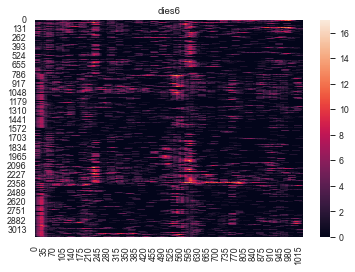

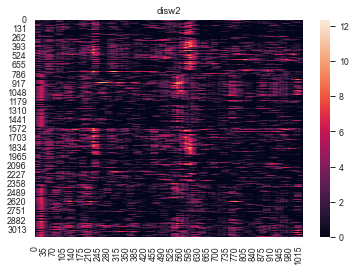

In [93]:
sns.heatmap(wt_smooth)
plt.title("wt")
plt.show()
sns.heatmap(dies6_smooth)
plt.title("dies6")
plt.show()
sns.heatmap(disw2_smooth)
plt.title("disw2")
plt.show()

In [94]:
x = wt_smooth[100,284:780]
valleys = signal.find_peaks(x, height = (None, 1), plateau_size=10)[0]

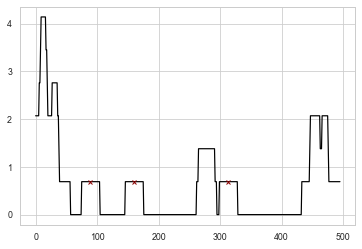

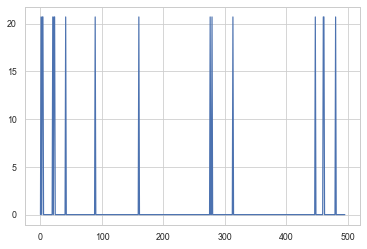

In [95]:
plt.plot(x, color = "black")
plt.plot(valleys, x[valleys], "x", color = "darkred")
plt.show()

plt.plot(wt_norm[100,284:780])

In [96]:
x = wt_norm[100,284:780]
vall, vall_prop = signal.find_peaks(-x, width=45)

In [97]:
vall_prop

{'prominences': array([20.71122341, 20.71122341, 20.71122341, 20.71122341]),
 'left_bases': array([ 41,  89, 160, 313]),
 'right_bases': array([ 89, 160, 276, 447]),
 'widths': array([ 47.,  70., 115., 133.]),
 'width_heights': array([-10.35561171, -10.35561171, -10.35561171, -10.35561171]),
 'left_ips': array([ 41.5,  89.5, 160.5, 313.5]),
 'right_ips': array([ 88.5, 159.5, 275.5, 446.5])}

Text(0.5, 1.0, 'Detected peaks with min_width=45 from mirrored data and widths')

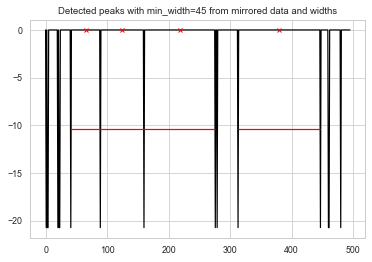

In [98]:
plt.plot(-x, color="black")
plt.plot(vall, -x[vall], "x", color = "red")
plt.hlines(y=vall_prop["width_heights"], xmin=vall_prop["left_bases"],
            xmax=vall_prop["right_bases"], color = "red")
plt.title("Detected peaks with min_width=45 from mirrored data and widths")

In [99]:
def measure_valley(array2D, width_range:tuple = (40,70)):
    #define dataframe to store peak information in 
    peak_sums = pd.DataFrame({"left_bases" : None,
                            "widths" : None} , 
                            index = range(array2D.shape[0]))
    
    for index, row in enumerate(array2D):
        _, peak_array = signal.find_peaks(-row, width= width_range) # only store peaks between 45 and 70 bases
        peak_sums.loc[index, "left_bases"] = list(peak_array["left_bases"])
        peak_sums.loc[index, "widths"] = list(peak_array["widths"])
    return peak_sums

In [100]:
def restore_peaks(peak_summary_df, output_shape:tuple):
    # define array of zeros in output shape, et regions of peaks to one
    zeros_array = np.zeros(output_shape)
    # loop over peak summary dataframe
    for row_num in range(peak_summary_df.shape[0]):
        #check if there are detected peaks for this molecule
        if peak_summary_df.loc[row_num, "widths"]:
            left_pos = peak_summary_df.loc[row_num, "left_bases"]
            widths = peak_summary_df.loc[row_num, "widths"]
            for ind, _ in enumerate(left_pos):
                zeros_array[row_num, left_pos[ind]: (left_pos[ind] + int(widths[ind]))] = 1
                #set stretches for peak width to 1
    return zeros_array

In [101]:
width_range = (140,160)
peaks_wt = measure_valley(wt_norm, width_range = width_range) #[:,284:780]
rebuild_wt = restore_peaks(peaks_wt, wt_norm.shape) #[:,284:780]

In [102]:
wt_rep3_maxnorm.shape, wt_rep2_maxnorm.shape
peaks_wt["strand"] = pd.Series(["plus", "minus", "plus", "minus"]).repeat([780,780,492,492]).reset_index(drop=True).astype("category")
peaks_wt["sum_valleys"] = [len(list) for list in peaks_wt.widths]

Text(0.5, 1.0, 'Number of valleys per molecule, range: (140, 160)')

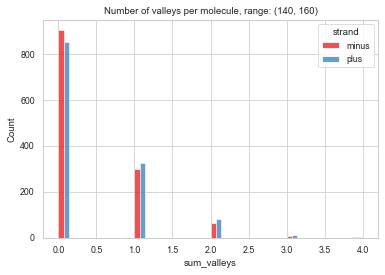

In [103]:
sns.histplot(data = peaks_wt, x = "sum_valleys", hue="strand", multiple = "dodge", palette = "Set1")
plt.title("Number of valleys per molecule, range: " + str(width_range))

In [104]:
#peaks_wt = peaks_wt.loc[peaks_wt.sum_valleys ==1, ].reset_index()
#rebuild_wt = restore_peaks(peaks_wt, (peaks_wt.loc[peaks_wt.sum_valleys ==1, ].reset_index().shape[0], 1033))

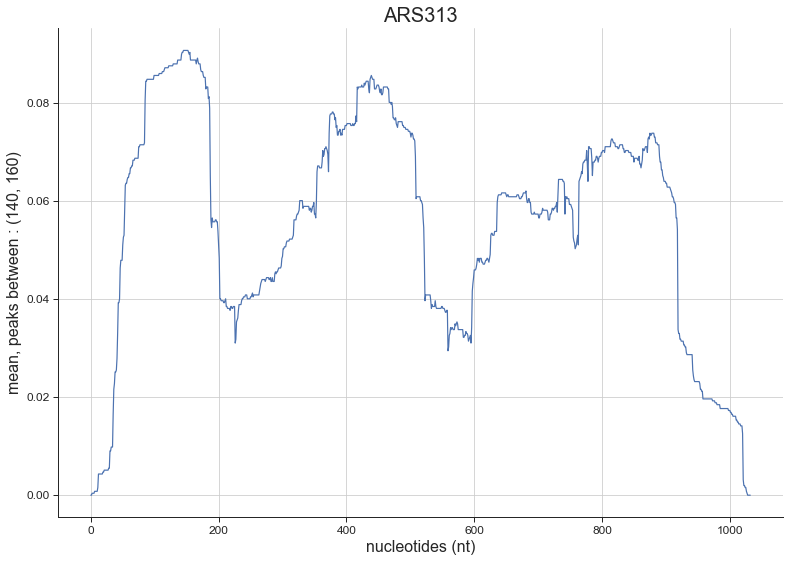

In [105]:
sns.set_context("paper")
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir , fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 16)
        plt.plot(rebuild_wt.mean(axis=0))
        plt.show()

In [106]:
peaks_dies6 = measure_valley(dies6_norm, width_range = width_range) #[:,284:780]
rebuild_dies6 = restore_peaks(peaks_dies6, dies6_norm.shape) #

peaks_disw2 = measure_valley(disw2_norm, width_range = width_range) #[:,284:780]
rebuild_disw2 = restore_peaks(peaks_disw2, disw2_norm.shape) #[:,284:780]

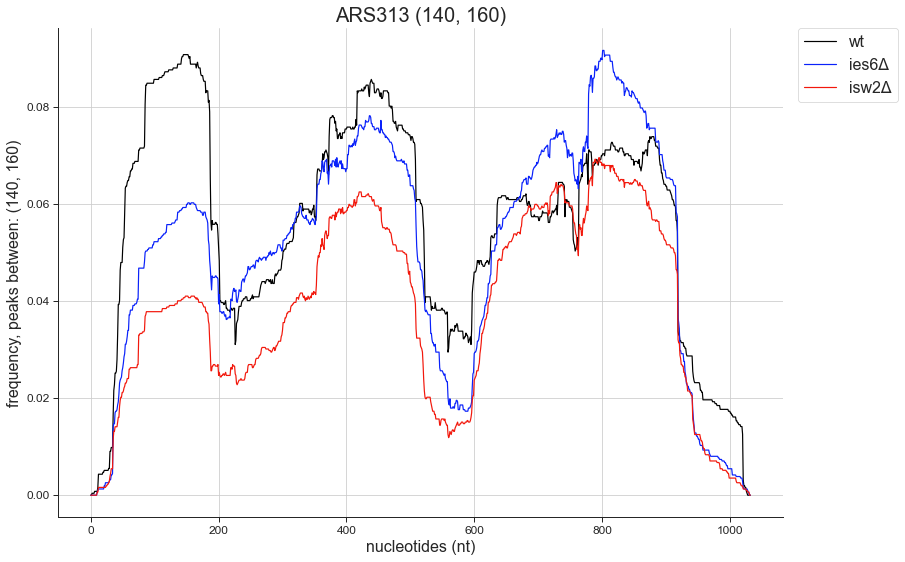

In [108]:
sns.set_context("paper")
#sns.set(style = "whitegrid", font_scale=1.5)
with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):

        plt.figure(figsize = (13, 9))
        #plt.fill_betweenx((0, 0.13), 285, 707, 
         #             color = "gold", alpha = 0.2)
        sns.lineplot(#x = range(284, 780),
            x = range(wt_norm.shape[1]),
             y = rebuild_wt.mean(axis=0),
             color = "black", 
            label = "wt")
        sns.lineplot(#x = range(284, 780),
            x = range(wt_norm.shape[1]),
             y = rebuild_dies6.mean(axis=0), 
             color = "#0a22fa",# alpha = 0.7,
            label = "ies6Δ")
        sns.lineplot(#x = range(284, 780),
            x = range(wt_norm.shape[1]),
            y = rebuild_disw2.mean(axis=0), 
            color = "#f2180c",# alpha = 0.7,
            label = "isw2Δ")
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title(load_dir +" " + str(width_range), fontsize=20
          #+  ", mean normalised and pooled, smoothened with " + str(N)
                  )
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("frequency, peaks between: " + str(width_range), fontsize = 16)
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize = 16)
        
        #plt.savefig(load_dir + "/plots/ARS313_distribution_peaks_50_60.pdf", dpi=300, bbox_inches = "tight")
        plt.show()

## Edit 2023/09/08: incorporate cluster information when detecting footprints of Mcm and nucleosomes

In [109]:
cluster_info_df = pd.read_csv("ARS313/ARS313_postive_strands_feature_meth_window30_clusters.csv")

# check the number of molecules per strand

#nrows = 0
#for replicate in [wt_rep3_maxnorm, wt_rep2_maxnorm, dies6_rep1_maxnorm, 
#             dies6_rep2_maxnorm, disw2_rep1_maxnorm, disw2_rep2_maxnorm]:
#    nrows += replicate.shape[0]
#print(int(nrows/2))

#construct a df with binary matrices for all replicates and replicate annotation

all_data= pd.DataFrame()

for (array, name) in zip([wt_rep3_maxnorm, wt_rep2_maxnorm, 
                                  dies6_rep1_maxnorm, dies6_rep2_maxnorm,
                                  disw2_rep1_maxnorm, disw2_rep2_maxnorm],
                ["wt rep3", "wt rep2", "dies6 rep1", "dies6 rep2", "disw2 rep1", "disw2 rep2"]):
    inter = pd.DataFrame(array)
    inter["molecule"] = inter.index
    inter["replicate"] = name
    inter["strand"] = ["plus" if i<inter.shape[0]//2 else "minus" for i in range(inter.shape[0])]
    all_data = pd.concat([all_data, inter], axis = 0)

all_data_plus = all_data.loc[all_data.strand == "plus"].merge(cluster_info_df.loc[:, ["replicate", "molecule", "cluster"]], 
                on = ["replicate", "molecule"], how = "inner")
all_data_plus.head()

,0,1,2,3,4,5,6,7,8,9,...,1027,1028,1029,1030,1031,1032,molecule,replicate,strand,cluster
0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,wt rep3,plus,2
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,wt rep3,plus,2
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,wt rep3,plus,2
3,0.000000,0.0,0.0,0.000000,0.000000,20.711223,0.0,20.711223,20.711223,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,wt rep3,plus,2
4,20.711223,0.0,0.0,20.711223,20.711223,20.711223,0.0,20.711223,20.711223,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4,wt rep3,plus,5


In [110]:
sns.set(style = "whitegrid", font_scale=1.5)
sns.set_context("paper")

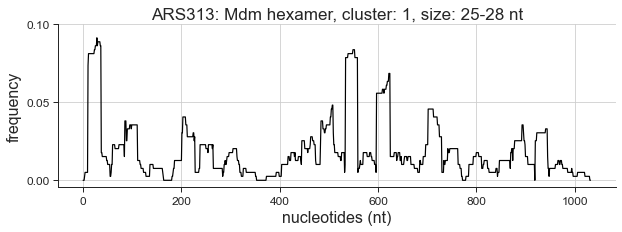

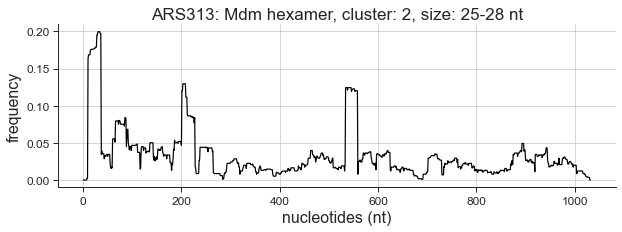

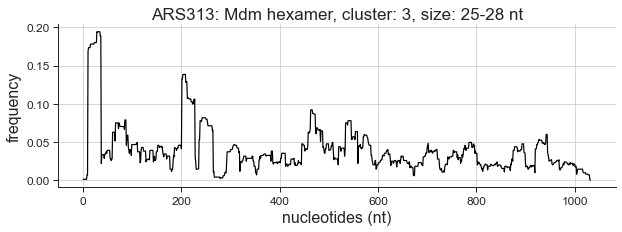

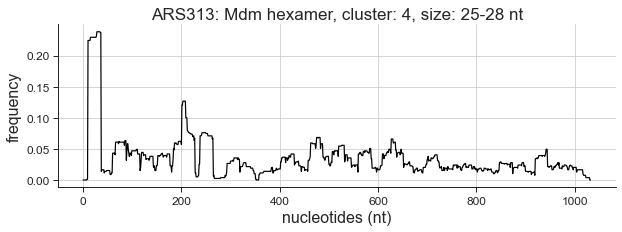

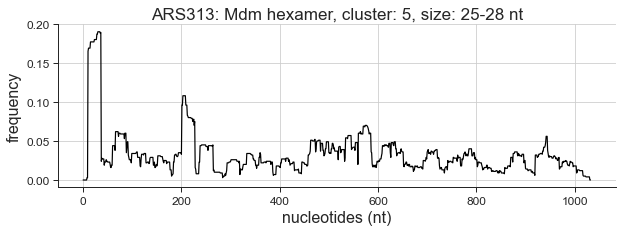

In [111]:
width_range = (25,29)

for cluster in set(all_data_plus.cluster):
    
    
    with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1032])
    
        peaks_temp = measure_valley(data_temp, width_range = width_range)
        rebuild_temp = restore_peaks(peaks_temp, data_temp.shape)
    
        plt.figure(figsize = (10,3))
        plt.plot(rebuild_temp.mean(axis=0), color = "black")
        #plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 15)
        plt.title(load_dir + ": Mdm hexamer, cluster: " + str(cluster) +", size: 25-28 nt", fontsize=17)
        
        plt.xticks(fontsize=12)
        #plt.yticks(fontsize=12)
        plt.yticks(np.arange(0, rebuild_temp.mean(axis=0).max() + 0.01, 0.05), fontsize=12)
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("frequency", fontsize = 16)
        
        #plt.savefig(load_dir + "/plots/ARS313_footprint_26nt_" + str(cluster) + ".pdf")
        #plt.ylim((0, 0.2))
        plt.show()        

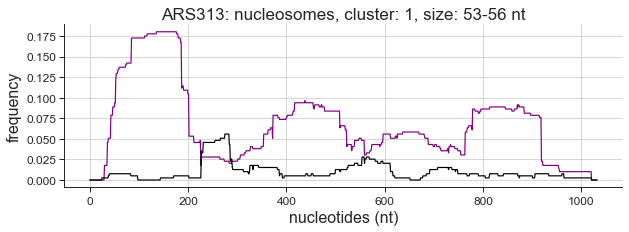

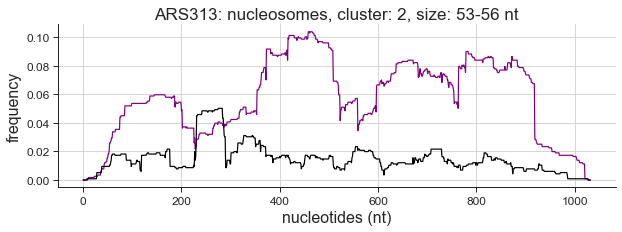

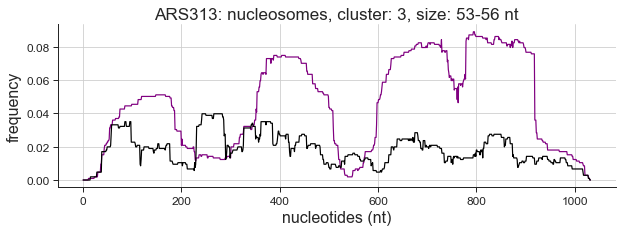

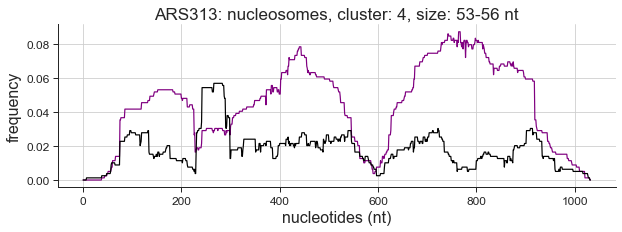

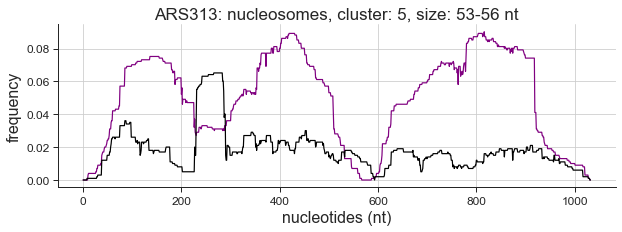

In [112]:
width_range = (57,60)

for cluster in set(all_data_plus.cluster):
    
    
    with sns.axes_style("ticks", {'axes.grid': True, 'axes.spines.right': False, 'axes.spines.top': False}):
        data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1032])
    
        peaks_temp = measure_valley(data_temp, width_range = width_range)
        rebuild_temp = restore_peaks(peaks_temp, data_temp.shape)
        
        peaks_nuc = measure_valley(data_temp, width_range = (140,160))
        rebuild_nuc = restore_peaks(peaks_nuc, data_temp.shape)
    
        plt.figure(figsize = (10,3))
        
        plt.plot(rebuild_nuc.mean(axis=0), color = "purple")
        
        plt.plot(rebuild_temp.mean(axis=0), color = "black")
        #plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 15)
        plt.title(load_dir + ": nucleosomes, cluster: " + str(cluster) +", size: 53-56 nt", fontsize=17) #
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        #plt.yticks(np.arange(0, rebuild_temp.mean(axis=0).max() + 0.01, 0.04), fontsize=12)
        plt.xlabel("nucleotides (nt)", fontsize=16)
        plt.ylabel("frequency", fontsize = 16)
        
        #plt.savefig(load_dir + "/plots/ARS305_footprint_Mdm_" + str(cluster) + ".pdf")
        #plt.ylim((0, 0.2))
        plt.show() 

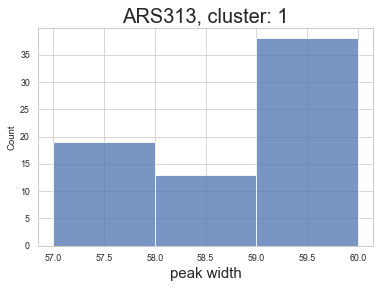

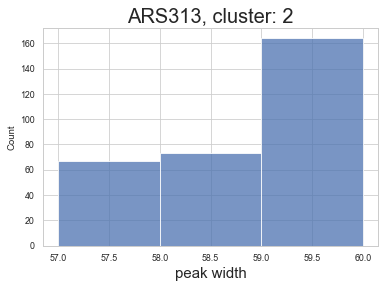

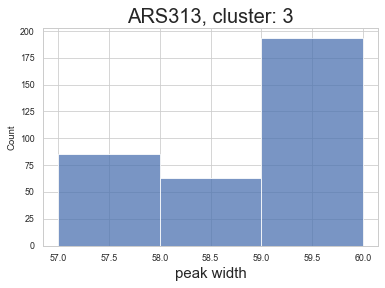

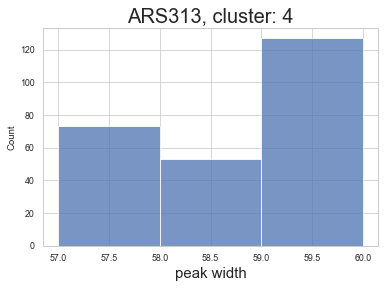

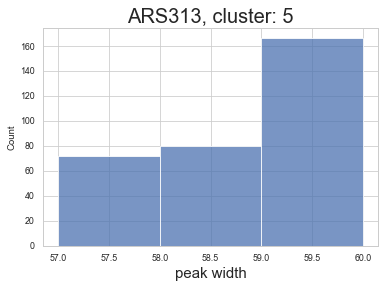

In [114]:
for cluster in set(all_data_plus.cluster):
    
    data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1032])
    
    peaks_temp = measure_valley(data_temp, width_range = width_range)
    rebuild_temp = restore_peaks(peaks_temp, data_temp.shape)

    listofpeakwidths = []

    for row in peaks_temp.widths:
        listofpeakwidths = listofpeakwidths + row
    
    sns.histplot(listofpeakwidths, binwidth=1)
    plt.title(load_dir + ", cluster: " + str(cluster) , fontsize=20)
    plt.xlabel("peak width", fontsize=15)
    plt.show()

In [115]:
all_data_plus.cluster.value_counts()

2    1157
3    1055
5     997
4     789
1     394
Name: cluster, dtype: int64

In [116]:
all_data_plus["condition"] = all_data_plus.replicate.map({'dies6 rep1':"dies6", 'dies6 rep2':"dies6", 'disw2 rep1': "disw2", 'disw2 rep2':"disw2", 
                             'wt rep2':"wt", 'wt rep3':"wt"})

/var/folders/8_/bz0k3bkj70x4ylymbhp02t4n19gw28/T/ipykernel_85539/2973119205.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(data.iloc[:,:1238].mean(axis=0))


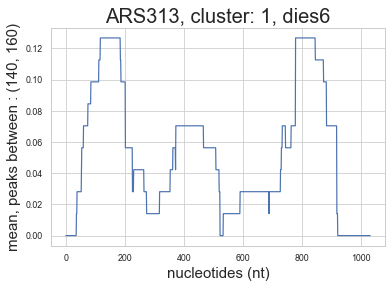

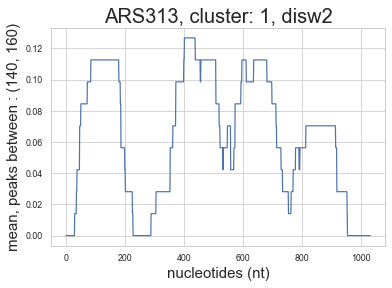

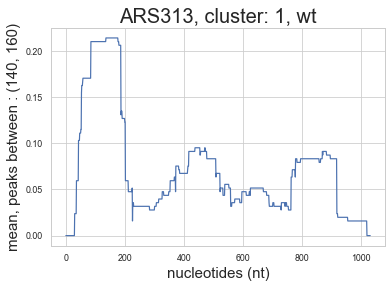

/var/folders/8_/bz0k3bkj70x4ylymbhp02t4n19gw28/T/ipykernel_85539/2973119205.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(data.iloc[:,:1238].mean(axis=0))


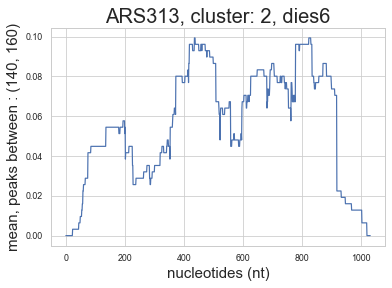

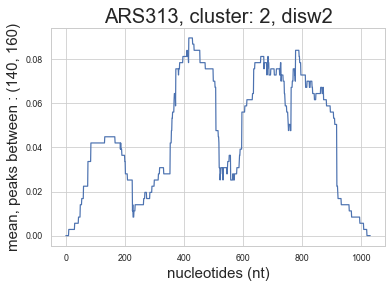

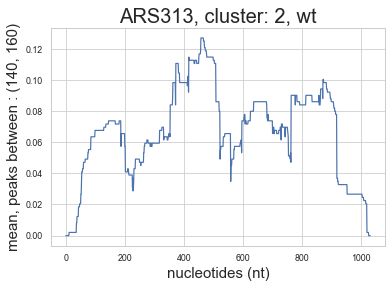

/var/folders/8_/bz0k3bkj70x4ylymbhp02t4n19gw28/T/ipykernel_85539/2973119205.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(data.iloc[:,:1238].mean(axis=0))


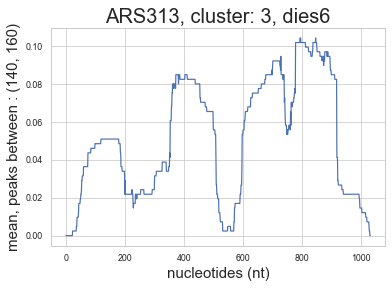

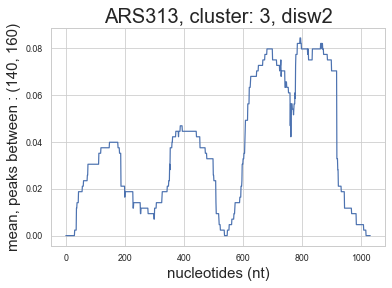

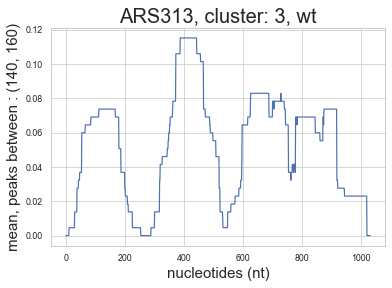

/var/folders/8_/bz0k3bkj70x4ylymbhp02t4n19gw28/T/ipykernel_85539/2973119205.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(data.iloc[:,:1238].mean(axis=0))


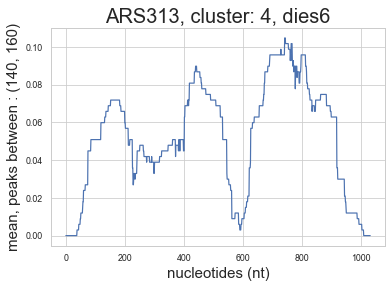

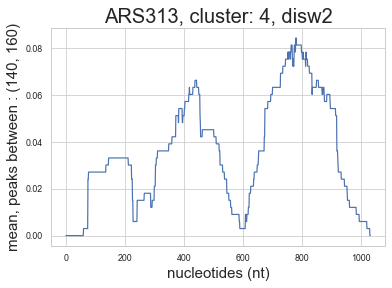

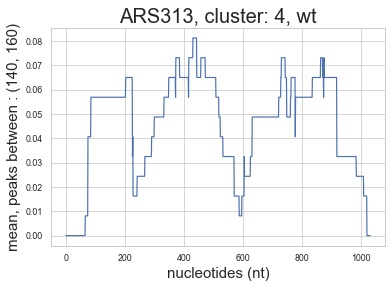

/var/folders/8_/bz0k3bkj70x4ylymbhp02t4n19gw28/T/ipykernel_85539/2973119205.py:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(data.iloc[:,:1238].mean(axis=0))


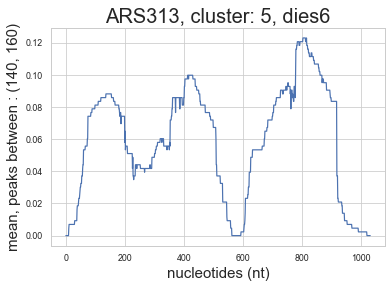

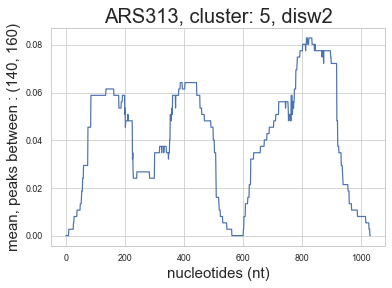

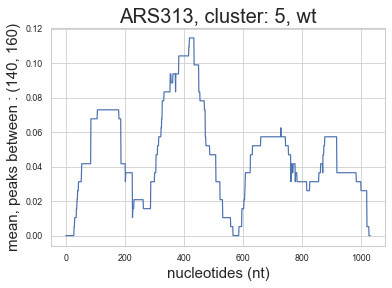

In [120]:
width_range = (140,160) #26,28

for cluster in set(all_data_plus.cluster):
    
    data_temp = np.array(all_data_plus.loc[all_data_plus.cluster == cluster, :1032])
    
    peaks_temp = measure_valley(data_temp, width_range = width_range)
    rebuild_temp = pd.DataFrame(restore_peaks(peaks_temp, data_temp.shape))
    rebuild_temp["condition"] = all_data_plus.loc[all_data_plus.cluster == cluster, "condition"].reset_index(drop=True)
    #rebuild_temp["peaks_number"] = pd.Series([len(row) for row in peaks_temp.widths])
    
    for rep in set(rebuild_temp.condition):
        data = rebuild_temp.loc[rebuild_temp.condition == rep,:]
        #data = data[data.peaks_number != 0]
        
        #sns.histplot(data.loc[:, "replicate"])
        #plt.show()
        
        plt.plot(data.iloc[:,:1238].mean(axis=0))
        plt.title(load_dir + ", cluster: " + str(cluster) +", " + str(rep), fontsize=20)
        plt.xlabel("nucleotides (nt)", fontsize=15)
        plt.ylabel("mean, peaks between : " + str(width_range), fontsize = 15)
        plt.show()
        

## How sparse can we expect the signal to be in the annotated features?

In [ ]:
seq="ATGAAAGAATACGTTATTCTTTCATCAAATCGTGGTCGACCGGCATGCAAGCTCCGAAAGATTGGGAGTTGGTAGACCTTTTGGTCGTTAATGAAATTGAGGGTCTTCAAATCGTGGAAAGTGTATTTGATAATGAACTTGTTGAAGAAATAAGGGAGAAGATAAAGGACGACTTTTTAGGAGAATATCGTAAAATTTGTGAGCTTTTGTATGAAAAACTCATGAATCGAAAGAAAAGAGGAATTGTGGTTATGACTTTGGGTTCGAGAGGGGTGCTTTTCTGTTCGCACGAAAGCCCTGAAGTACAATTCCTTCCGGCTATTCAAAATGTTTCGGTTGTTGATACTACAGGAGCTGGAGATACTTTCCTGGGCGGTTTGGTTACTCAATTGTATCAAGGAGAGACCTTGTCTACGGCTATAAAGTTCTCTACATTAGCTAGTTCATTGACCATTCAAAGAAAAGGTGCTGCTGAAAGCATGCCACTGTATAAAGATGTTCAGAAAGATGCATAAAATCTACTGCAATTTTTTACTTTTAGTTTGTTAAATTTTAGTTTTCGTCATATATATAAAGTTTAAAAAGGTACAAAGAATGCAGTAATAAGAAATGTAATTACATGAGGGCAGTTTAAGTGCTACCTTTTAAGACGGAAGAACTAATACCATAACCGAGAGTAATTACGCAGACAAACGCTAACAACGAAGCAGGAACACCTCTGGAGATAAAAGCGCCTACAGTTAGCCATCTATTACCCTTTTTATCGGTCATAGAAATAGCAGTAACGTTTGGAAATCCAGATGAAGCCAACCCCATACCGCATGAGGCTAACAAGGCGCAACCGAACACAAGAATTGGAGCTGCCTTTGGATCGGATAATTTGTCACCAACTTCTTGCACCAAGGGAATAATGATGATTGCTGACACAGTATGTGAGACAAAAGTGCCCACAACTAACATTAAAATACCGAAAATACATAAGATAGCAAAAACACCATCGTTCTGAATTTTCTTTTGTAATGCTCTTGCAATA"
seq = seq.lower()
seq_char = anno.drop(columns = "position")

array_list = [seq[seq_char.loc[index, "pos_start"]:seq_char.loc[index, "pos_stop"]] for 
 index in seq_char.index]

seq_char["sequence"] = pd.Series(array_list, index = seq_char.index)

seq_char["a_percent"] = [row.count("a")/len(row)*100 for row in seq_char["sequence"]]
seq_char["t_percent"] = [row.count("t")/len(row)*100 for row in seq_char["sequence"]]
seq_char["cg_percent"] = [row.count("cg")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_percent"] = [row.count("gc")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_content"] = [(row.count("c")+row.count("g"))/len(row)*100 for row in seq_char["sequence"]]
seq_char.drop(columns = "sequence", inplace=True)

seq_char

## Plot the methylation frequency for the whole sequence of the origin:

In [ ]:
#prepare the data:
#eff_df = pd.DataFrame({"wt_rep3": wt_rep3.mean(axis=0)}, index=range(1033))
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1033))

eff_df["base"] = [letter for letter in seq]
#eff_df["wt_rep2"] = wt_rep2.mean(axis=0)
#eff_df["dies6_rep1"] = dies6_rep1.mean(axis=0)
#eff_df["dies6_rep2"] = dies6_rep2.mean(axis=0)
#eff_df["disw2_rep1"] = disw2_rep1.mean(axis=0)
#eff_df["disw2_rep2"] = disw2_rep2.mean(axis=0)

eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS313")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide in plasmid controls")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Normalized methylation over samples")

g

In [ ]:
#Exporting aggregated data for Anna to plot for the manuscript 
#31th May 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS313_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS313_smooth_30.index = ARS313_smooth_30.index + 1
#ARS313_smooth_30.to_csv("ARS313/ARS313_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

ARS313_FCs = pd.DataFrame.from_dict(FC)
ARS313_FCs.index = ARS313_FCs.index + 1

#ARS313_FCs.to_csv("ARS313/ARS313_smoothed_fold_changes_winsize_30.csv")